# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions.graph_tools import *
from models.nmf import *
from functions import cosmic_val
from functions import data_handling as dh


# set seed
# np.random.seed(15)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
LATENT_DIM = 4
TOLERANCE = 1e-4
MAX_ITERATIONS = 100_000_000
SPLIT = 0.8

In [6]:
losses_train = []
losses_test = []
signatures = []
iterations = 30


for i in tqdm(range(iterations)):


    # Extract train and test data
    train_data = data.sample(frac = SPLIT, axis = 1)
    test_data = data.drop(train_data.columns, axis = 1)
    
    # Applying NMF
    signatures_nmf, exposures_nmf, loss_nmf = nmf(catalog_matrix = train_data.to_numpy(),
                                                  num_sign = LATENT_DIM,
                                                  tol = TOLERANCE,
                                                  max_iter = MAX_ITERATIONS)
    

    # Refitting NMF (test data)

    losses_refit = refit_NMF(test_data.to_numpy(), signatures_nmf)
    losses_test.append(losses_refit[-1])

    # Calculating signatures and exposures for NMF
    diagonals_nmf = signatures_nmf.sum(axis=0)
    exposures_nmf = exposures_nmf.T @ np.diag(diagonals_nmf)
    signatures_nmf = (signatures_nmf) @ np.diag(1 / diagonals_nmf)
    
    losses_train.append(loss_nmf[-1])
    signatures.append(signatures_nmf)



100%|██████████| 30/30 [40:47<00:00, 81.59s/it]   


In [7]:
print("Losses train: ", np.mean(losses_train))
print("Losses test: ", np.mean(losses_test))

Losses train:  15930.608734141979
Losses test:  66276.97350370079


In [8]:
all_signatures = np.hstack(signatures)

In [9]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [10]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [11]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0    SBS5      0.633334
1            1  SBS40c      0.847970
2            2  SBS10a      0.930514
3            3  SBS10c      0.725424

Mean similarity of the matched signatures:  0.7843106704884281


In [12]:
all_matches = cosmic_val.compute_all_matches(all_signatures, cosmic, n_runs = 4)

In [13]:
all_matches

,True_0,Similarity_0,True_1,Similarity_1,True_2,Similarity_2,True_3,Similarity_3,True_4,Similarity_4,...,True_25,Similarity_25,True_26,Similarity_26,True_27,Similarity_27,True_28,Similarity_28,True_29,Similarity_29
0,SBS40a,0.804592,SBS10a,0.932856,SBS44,0.836317,SBS57,0.798405,SBS6,0.909738,...,SBS44,0.863025,SBS13,0.716976,SBS13,0.753854,SBS6,0.893030,SBS10a,0.931577
1,SBS40c,0.792978,SBS44,0.843888,SBS10c,0.660596,SBS10a,0.931226,SBS3,0.884484,...,SBS10c,0.739597,SBS10c,0.736315,SBS10c,0.765441,SBS57,0.733162,SBS44,0.842155
2,SBS10a,0.928231,SBS10c,0.652926,SBS40a,0.724586,SBS40a,0.693766,SBS13,0.795623,...,SBS3,0.776865,SBS44,0.821836,SBS5,0.822291,SBS10a,0.931745,SBS10c,0.725424
3,SBS6,0.916530,SBS40a,0.746803,SBS10a,0.931511,SBS6,0.860503,SBS44,0.874459,...,SBS10a,0.931442,SBS6,0.911496,SBS6,0.909313,SBS13,0.712808,SBS40a,0.704778


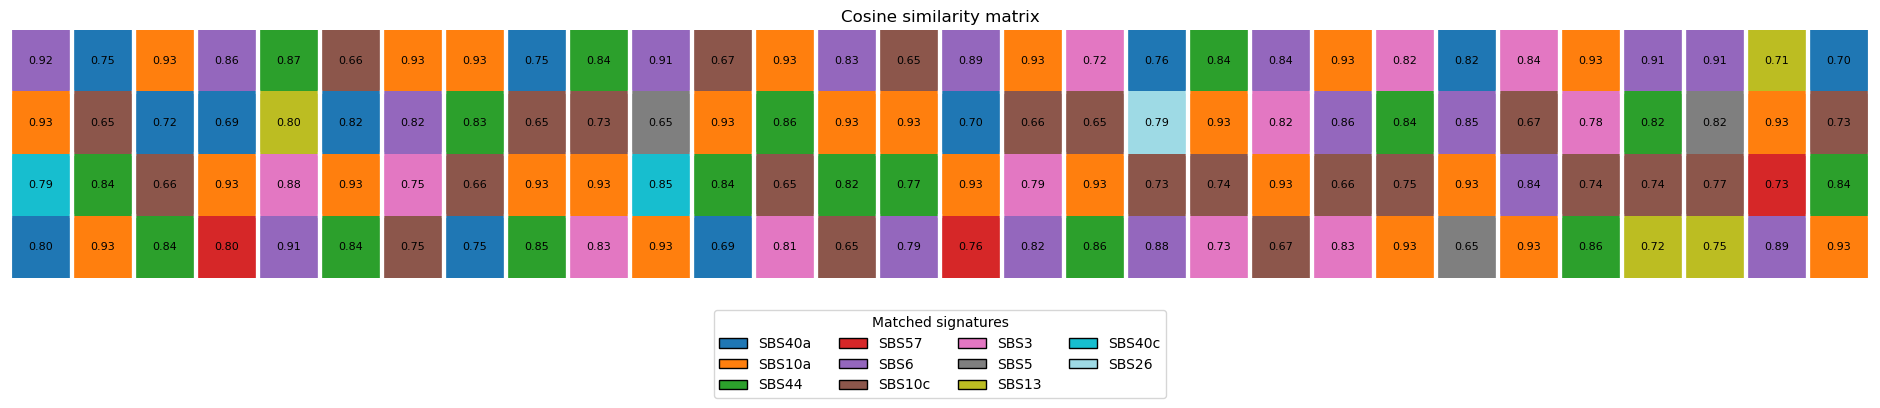

In [14]:
plot_cosine_similarity_matrix(all_matches, title = "Cosine similarity matrix", figsize=(24, 12), legend_colums=4, palette='tab20')

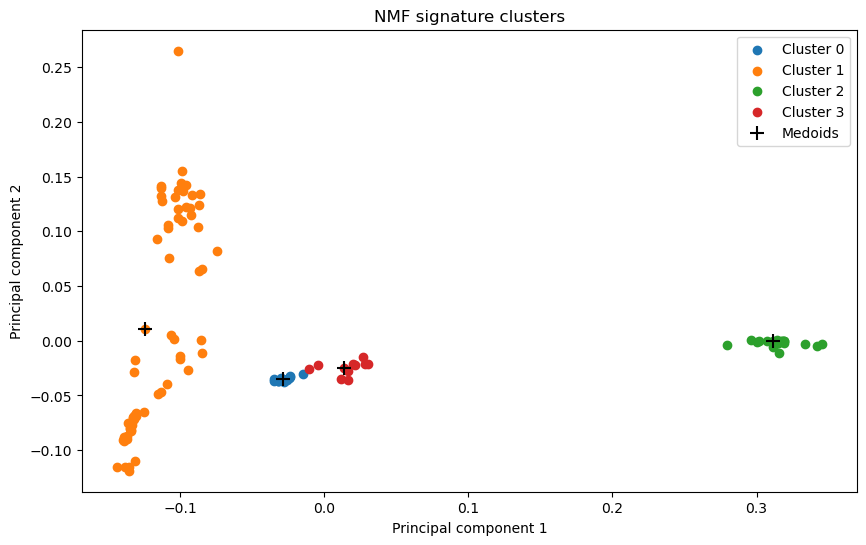

In [15]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "NMF signature clusters")

In [16]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

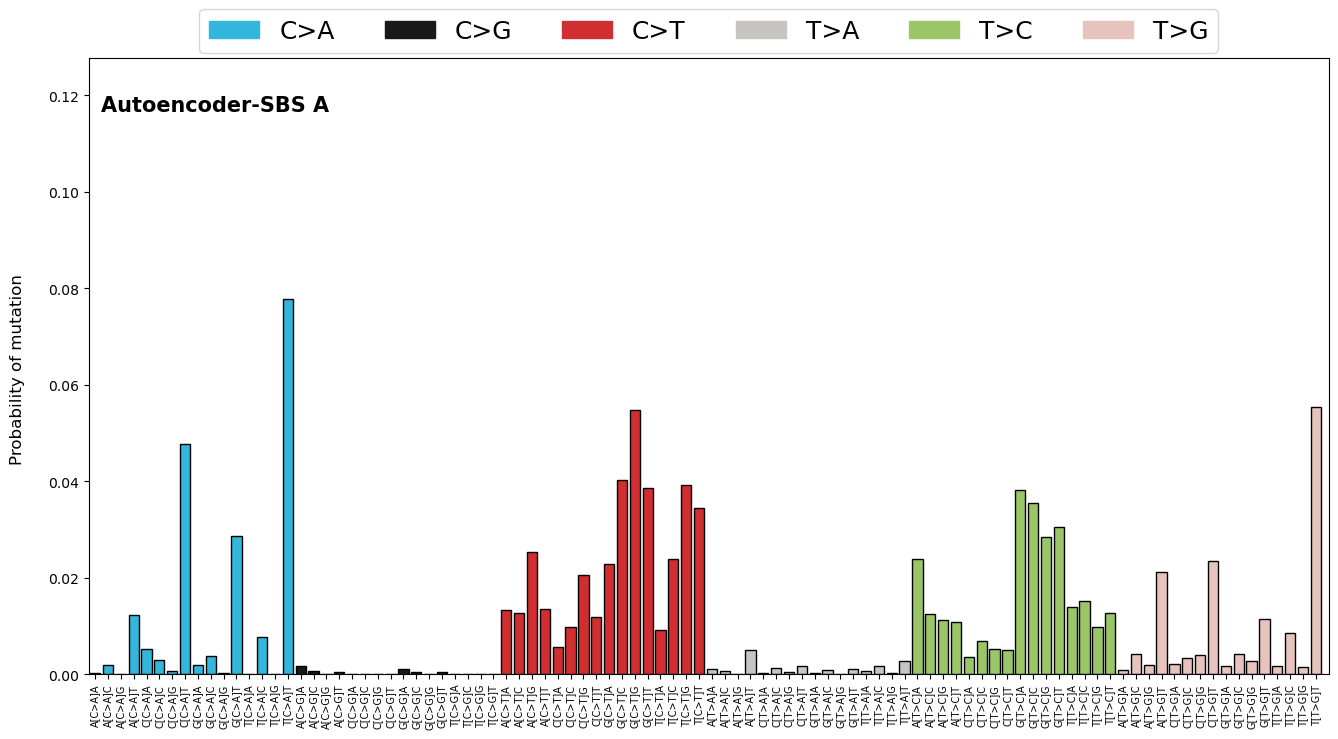

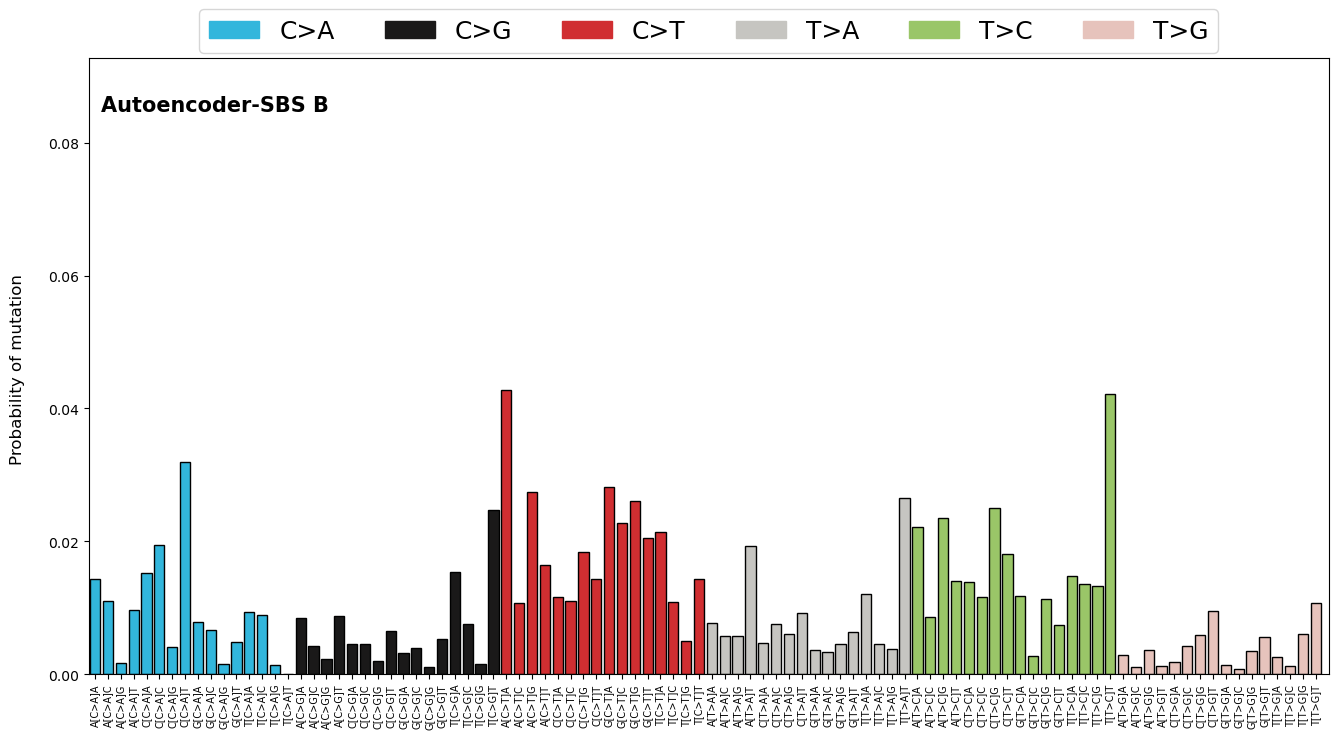

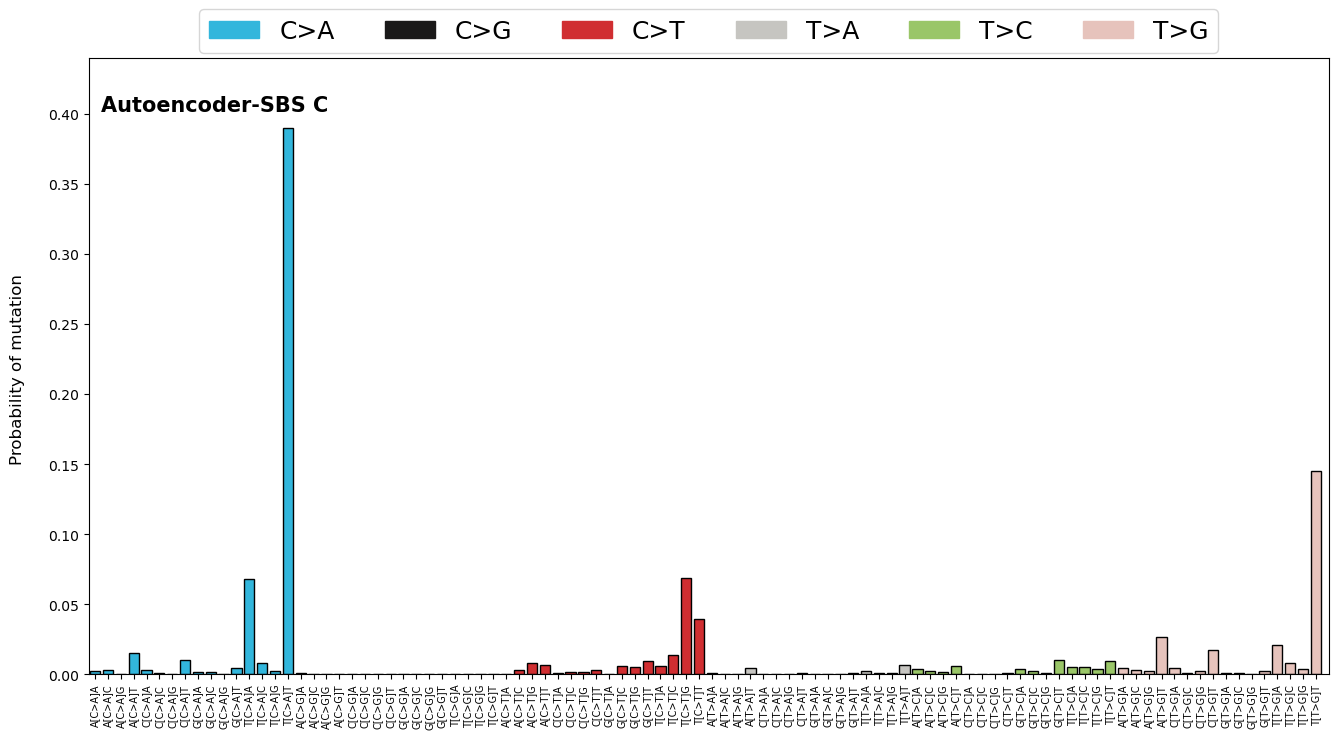

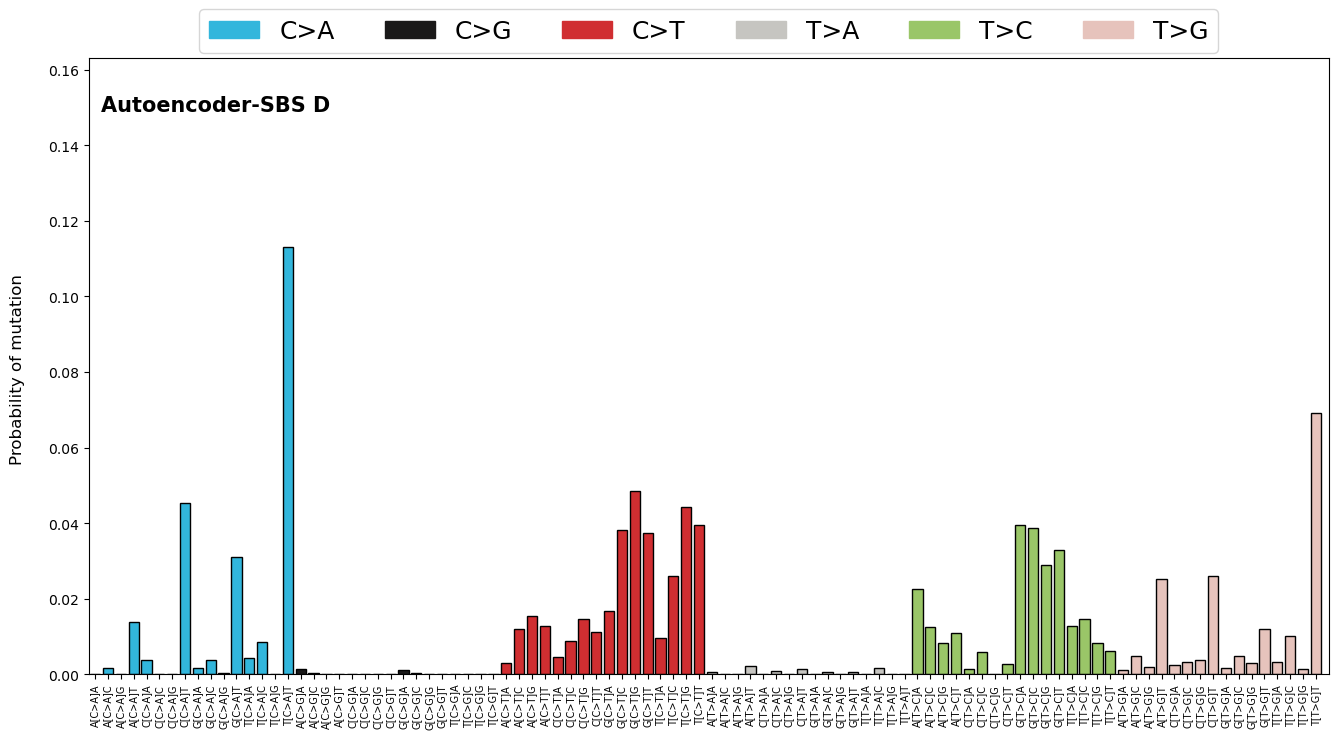

In [17]:
plot_signature(df_consensus)